In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull
from skimage import measure
import cv2
import math

# segment

In [2]:
#choice one image number num
def choice_image(image,num):
    numpy = image.get_fdata()
    numpy = numpy.T[num]
    return numpy

In [3]:
#choice the slice
#Function that display image slices
def show_slice(slices):
    plt.imshow(slices, cmap="gray", origin="lower")

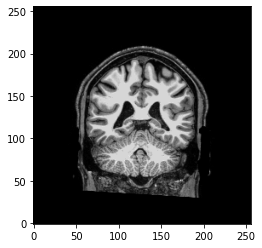

In [4]:
#for example choice number 100 slice 
image = nib.load('./raw_t1_subject_02.nii.gz')
num_segment = 100
image_brain_numpy = choice_image(image,num_segment) 
show_slice(np.flip(image_brain_numpy,axis=0))
 

In [5]:
#print(image.header)

In [6]:
# Functions that display CT slices with level, window
def Pretreatment(npslice, level, window):
    max = level + window/2
    min = level - window/2
    npslice = npslice.clip(min,max)
    plt.imshow(np.flip(npslice,axis=0), cmap="gray", origin="lower")
    return npslice 

contours  203


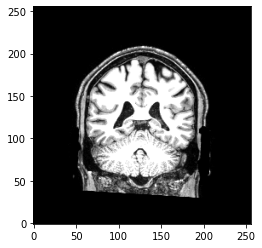

In [7]:
#Binarization of an image according to its intensity
def intensity_seg(ct_numpy, min, max):
    clipped = ct_numpy.clip(min, max)

    clipped[clipped != max] = 1
    clipped[clipped == max] = 0
    return measure.find_contours(clipped, 0.99) 

image_brain_numpy = Pretreatment(image_brain_numpy,40,80)
contours = intensity_seg(image_brain_numpy , min=0, max=50) 
print('contours ',len( contours))

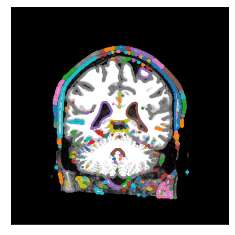

In [8]:
def show_contour(image, contours, name=None ):
    fig, ax = plt.subplots()
    #ax.imshow(image.T, cmap=plt.cm.gray)
    ax.imshow(image, cmap=plt.cm.gray)
    # Each contour in the returned contour list from  measure.find_contours 
    # diff colour
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)   
    ax.set_xticks([])
    ax.set_yticks([])
    
        
        
show_contour(image_brain_numpy, contours)

In [9]:
#Euclidean distance between points of Contour array
def contour_distance(contour):

    dx = contour[0, 1] - contour[-1, 1]
    dy = contour[0, 0] - contour[-1, 0]
    #Euclidean distance between the first coordinate point and the last coordinate point
    return np.sqrt(np.power(dx, 2) + np.power(dy, 2))

# Determine true or false according to contour closure
def set_is_closed(contour):
    if contour_distance(contour) < 1:
        return True
    else:
        return False

In [10]:
def find_brain(contours):
    body_and_brain_contours = []
    vol_contours = []

    for contour in contours:
        hull = ConvexHull(contour)

        # Set pixel limit
        if hull.volume > 2000 and set_is_closed(contour):
            body_and_brain_contours.append(contour)
            vol_contours.append(hull.volume)
            
    # Discard body contour
    if len(body_and_brain_contours) == 1:

        return body_and_brain_contours
    
    elif len(body_and_brain_contours) > 1:
        vol_contours, body_and_brain_contours = \
        (list(t) for t in zip(*sorted(zip(vol_contours, 
                                          body_and_brain_contours))))
        # Excluding the body contour, leaving only the brain contour
        body_and_brain_contours.pop(0)      
        return body_and_brain_contours


def find_allbrain(contours):
    body_and_brain_contours = []
    vol_contours = []

    for contour in contours:
        hull = ConvexHull(contour)

        # Set pixel limit
        if hull.volume > 2000 and set_is_closed(contour):
            body_and_brain_contours.append(contour)
            vol_contours.append(hull.volume)
            
    # Discard body contour
    return body_and_brain_contours

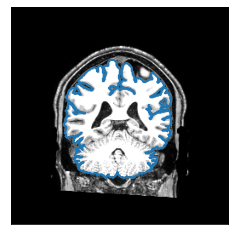

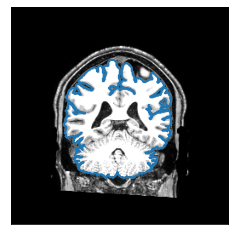

In [11]:
# Locate the contour of the brain area through the filter
brain_contours = find_brain(contours)
brain_contours1 = find_allbrain(contours)

# Draw brain detection contour

show_contour(image_brain_numpy, brain_contours)
show_contour(image_brain_numpy, brain_contours1)

In [12]:
#Create a binary mask with the same size as the image
def create_mask_from_polygon(image, contours):
    brain_mask = np.array(Image.new('L', image.shape, 0))
    for contour in contours:
        x = contour[:, 0]
        y = contour[:, 1]
        polygon_tuple = list(zip(x, y))
        img = Image.new('L', image.shape, 0)
        
        
        ImageDraw.Draw(img).polygon(polygon_tuple, outline=0, fill=1)
        mask = np.array(img)
        brain_mask += mask

    brain_mask[brain_mask > 1] = 1  

    return brain_mask.T


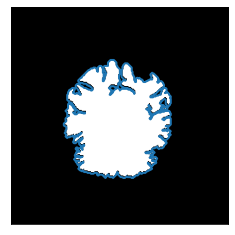

In [13]:
brain_mask = create_mask_from_polygon(image_brain_numpy, brain_contours)

#Draw brain detection contour
show_contour(brain_mask, brain_contours)
 

In [14]:
# Isolate the brain area
def create_cortical_mask(brain_mask, ct_numpy):
    cortical = brain_mask * ct_numpy  
    
    cortical[cortical == 0] = -1000
    cortical[cortical >= 80] = -1000
    cortical[cortical < 40] = -1000
    cortical[cortical >= 40] = 1000
    #print(' cortical', len( brain_contours))
    #-1000black +1000write
    show_slice(np.flip(cortical,axis=0))
    return cortical


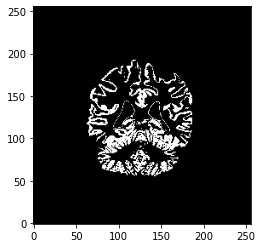

In [15]:
cortical = create_cortical_mask(brain_mask, image_brain_numpy)

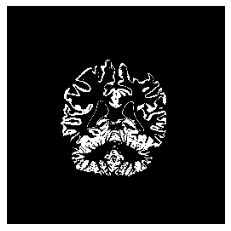

In [16]:
#save cortical image
 
plt.imshow(np.flip(cortical,axis=0), cmap="gray", origin="lower")
plt.axis('off') 
plt.xticks([])  
plt.yticks([])  
plt.savefig('./cortical_front '+ str(num_segment), bbox_inches = 'tight',pad_inches = 0)


# thickness

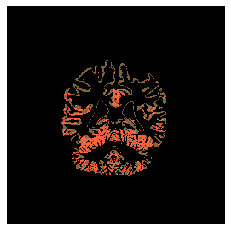

In [17]:
#Method 1
cort = np.array(cortical)

def distance_coclor(cortical1):
    cortical_x, cortical_y = np.nonzero(cortical1+1000)  # get whirt part
    for (x,y) in zip(cortical_x, cortical_y):
        if(x+5 <len(cortical1) and y+5 <len(cortical1) and x-5 >0 and y-5 >0):
            if((cortical1[x+5,y] != -1000 or cortical1[x-5,y] != -1000)
              and (cortical1[x,y+5] != -1000 or cortical1[x,y-5] != -1000)):
                cortical1[x,y] = 1000
            else:
                cortical1[x,y] = -2000
    return cortical1   


dis_cortical = distance_coclor(cort)
x_x, y_y = np.nonzero(dis_cortical)
for (x,y) in zip(x_x, y_y):
    if dis_cortical[x,y] == 1000:
        dis_cortical[x,y] = -1000
    else:
        dis_cortical[x,y] = 1000
        
plt.figure()
plt.imshow(dis_cortical , 'flag', interpolation='none' )
plt.imshow(cortical, 'copper', interpolation='none' , alpha=0.5 )

plt.axis('off') 
plt.xticks([])  
plt.yticks([])  
plt.savefig('./cortical1_front_thickness_map'+ str(num_segment), bbox_inches = 'tight',pad_inches = 0)


cortical_thickness.max() 7.0


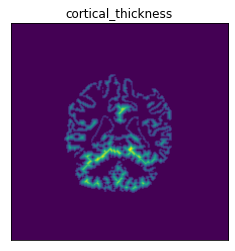

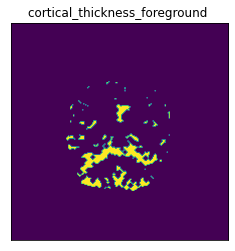

In [18]:
#Method 2
img = cv2.imread('./cortical_front '+str(num_segment)+'.png', 0)

img = cv2.fastNlMeansDenoising(img,None,10,7,21)#Denoising
#Calculate distance display thickness map
cortical_thickness = cv2.distanceTransform(img, cv2.DIST_L1, cv2.DIST_MASK_3)
#foreground of thickness map
ret, img_fore = cv2.threshold(cortical_thickness, 0.3 * cortical_thickness .max(), 255, cv2.THRESH_BINARY)
print('cortical_thickness.max()', cortical_thickness.max())

plt.imshow(cortical_thickness)
plt.title("cortical_thickness"), plt.xticks([]), plt.yticks([])
plt.show()

 
plt.imshow(img_fore)
plt.title("cortical_thickness_foreground "), plt.xticks([]), plt.yticks([])
plt.show()

 

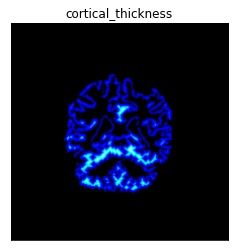

In [19]:
cortical_thickness1 = cv2.convertScaleAbs(cortical_thickness )
cortical_thickness2 = cv2.normalize(cortical_thickness1, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)
#heatmap
heat_cortical_thickness = cv2.applyColorMap(cortical_thickness2, cv2.COLORMAP_HOT)
heat_cortical_thickness = cv2.convertScaleAbs(heat_cortical_thickness, alpha=2, beta=0)
plt.imshow(heat_cortical_thickness)

plt.title("cortical_thickness"), plt.xticks([]), plt.yticks([])
plt.show()


cortical_thickness.max() 217


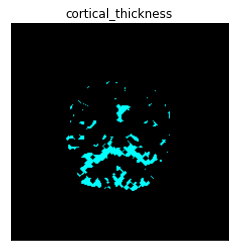

In [20]:
print('cortical_thickness.max()', len(cortical_thickness[0]))

heat_cortical_thickness_fore = heat_cortical_thickness
 
cortical_thickness1 = cv2.convertScaleAbs(img_fore )
cortical_thickness2 = cv2.normalize(cortical_thickness1, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)
heat_cortical_thickness_fore = cv2.applyColorMap(cortical_thickness2, cv2.COLORMAP_OCEAN)
#dyeing
rows,cols,channels = heat_cortical_thickness_fore.shape
for i in range(rows):
    for j in range(cols):
        for n in range(channels):
            if n ==0:    
                if heat_cortical_thickness_fore[i][j][n]==255:
                    heat_cortical_thickness_fore[i][j][n]=0
                    

plt.imshow(heat_cortical_thickness_fore)

plt.title("cortical_thickness"), plt.xticks([]), plt.yticks([])
plt.show()

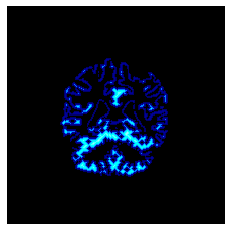

In [21]:
def overlay_and_save (i, j):
    plt.imshow(j,'flag' ,interpolation='none')
    plt.imshow(i,'flag', interpolation='none', alpha=0.6)
    plt.axis('off') 
    plt.xticks([])  
    plt.yticks([])  
    plt.savefig('./cortical2_front_thickness_map'+ str(num_segment), bbox_inches = 'tight',pad_inches = 0)
    
finaly_image = overlay_and_save(heat_cortical_thickness,heat_cortical_thickness_fore)
 